In [2]:
import json
from IPython.display import HTML
from matplotlib import animation, rc
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from ipywidgets import interact
file_name="afjorddance"
skeleton_fn= file_name+"_skeleton.json"
#a list of poses
with open(skeleton_fn) as file:
    sj_json = json.load(file)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,5)

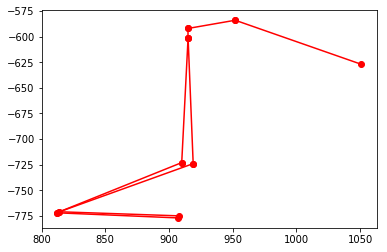

In [15]:
#visualise data
#joint numbers 
#convert to bottom left coordinate system
skeleton_frames=[]
for body_hand in sj_json:
    skeleton_frame=np.array(body_hand[0])
    skeleton_frame[:,1]=-1*skeleton_frame[:,1]
    skeleton_frames.append(skeleton_frame)

skeleton_frame=np.array(skeleton_frames[5])
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
              [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
              [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
len(skeleton_frame.shape)

# plt.scatter(skeleton_frame[:,0], skeleton_frame[:,1],c=np.array(colors)/255)
# plt.show()

limbSeq = [[2, 3], [2, 6], [3, 4], [4, 5], [6, 7], [7, 8], [2, 9], [9, 10], \
               [10, 11], [2, 12], [12, 13], [13, 14], [2, 1], [1, 15], [15, 17], \
               [1, 16], [16, 18], [3, 17], [6, 18]]
keypoints= [
            "nose","neck",
            "right_shoulder","right_elbow","right_wrist",
            "left_shoulder","left_elbow","left_wrist",
            "right_hip","right_knee","right_ankle",
            "left_hip","left_knee","left_ankle",
            "left_eye","right_eye","left_ear","right_ear"
        ]


def visualise_skeleton_frame(skeleton_frame):
    for i in range(18):
        points=skeleton_frame[np.array(limbSeq[i])-1]
        if  [-1,1] in points:
            continue
        plt.plot(points[:,0], points[:,1], 'ro-')
visualise_skeleton_frame(skeleton_frame)
#draw the name of the keypoints, but the image somehow jumps to the right corner
# for i, txt in enumerate(keypoints):
#     plt.annotate(txt, skeleton_frame[i])
plt.show()


In [50]:

def test(x):
    frame=np.array(skeleton_frames[x])
    visualise_skeleton_frame(frame)
    plt.show()
interact(test, x=(0,len(skeleton_frames)-1))
plt.show()

interactive(children=(IntSlider(value=247, description='x', max=494), Output()), _dom_classes=('widget-interac…

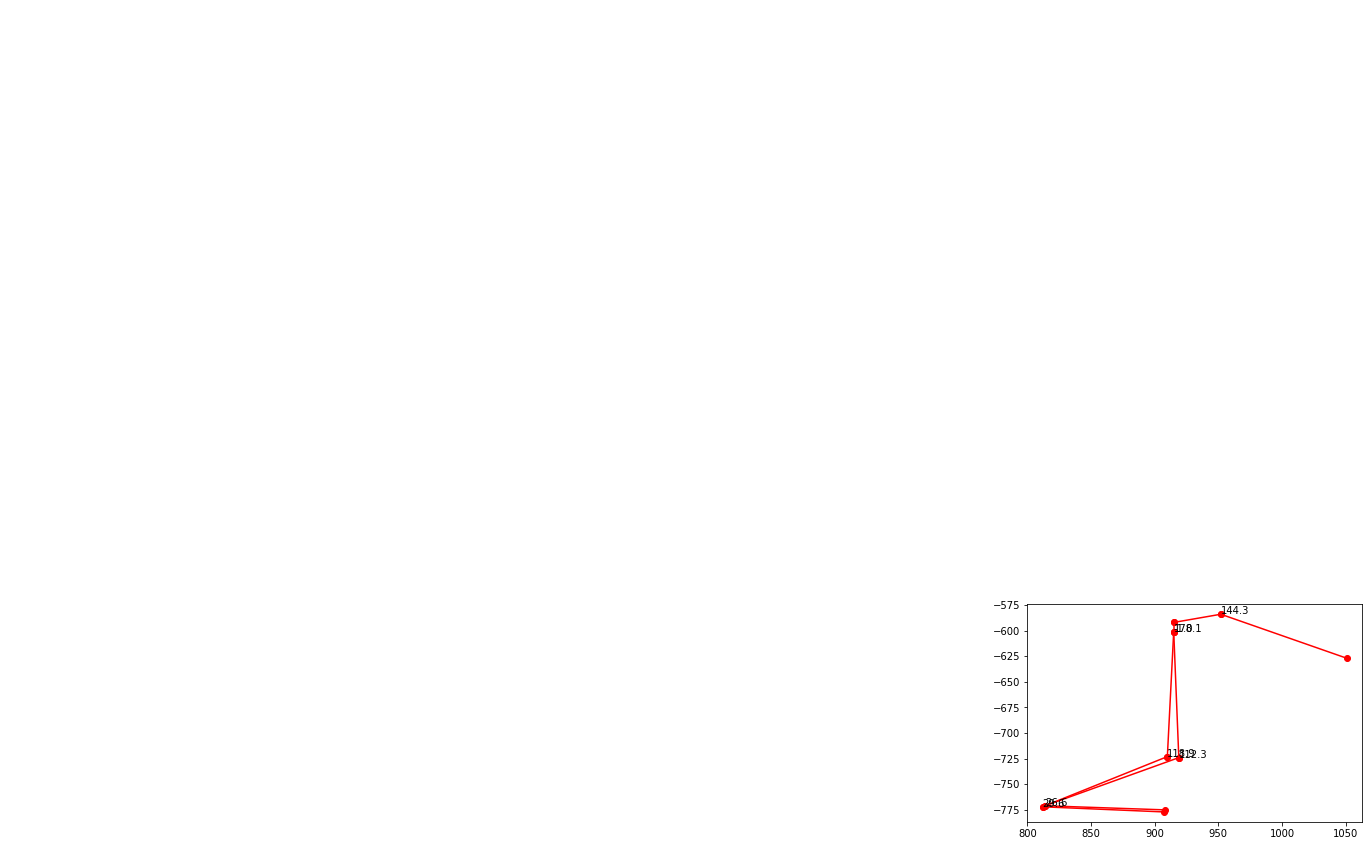

In [51]:
#calculate angles of major joints
def get_angle(a,b,c):
    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)
#angles of interest
#3 joint index to calculate angle
#right knee, right hip, left knee, left hip, right shoulder, right elbow, left shoulder, left elbow
joint_inds=[[10,9,8],[9,8,1],[13,12,11],[12,11,1],[11,1,2],[2,3,4],[11,1,5],[5,6,7]]
def calculate_joint_angles(skeleton_frame):
    angles=[]
    for joint_ind in joint_inds:
        joints_pos=skeleton_frame[joint_ind]
        #if the angle cannot be defined make it -1
        if [-1.,1.] in joints_pos:
            angles.append(-1)
        else:
            angles.append(get_angle(*skeleton_frame[joint_ind]))
        
    return angles
        
def visualise_joint_angles(skeleton_frame, angles):
    for angle_i,angle in enumerate(angles):
        plt.annotate(format(angle, ".1f"),skeleton_frame[joint_inds[angle_i][1]])
  
angels=calculate_joint_angles(skeleton_frame)
visualise_joint_angles(skeleton_frame,angels)
visualise_skeleton_frame(skeleton_frame)
plt.show()

In [55]:
#calculate the joint angle for each frame
frame_angles=np.zeros((len(skeleton_frames),len(joint_inds)))
#what is the order of the joint-angels?
for frame_i,frame_s in enumerate(skeleton_frames):
    angles = calculate_joint_angles(frame_s)
    for angle_i,angle in enumerate(angles):
        if angle is not -1:
            frame_angles[frame_i,angle_i]=angle
        #for all joint angels that are not found pad with previous value
        elif frame_i > 0:
            frame_angles[frame_i,angle_i]=frame_angles[frame_i-1][angle_i]
#TODO experiment with other ways to impute missing angle values
#mean is one simple univariate example but multivariate methods exist in sklearn
#TODO interpolate stuff (between fr)

def angle_viz(x):
    return frame_angles[x]
interact(angle_viz, x=(0, len(frame_angels)-1))


interactive(children=(IntSlider(value=247, description='x', max=494), Output()), _dom_classes=('widget-interac…

<function __main__.angle_viz(x)>

In [63]:
from pythonosc import osc_message_builder
from pythonosc import udp_client
import time
import sklearn
#reduce dimensions of joint angles to number of parameters in script (2)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import preprocessing as prep

#standardize (norm) distr
frame_angles=StandardScaler().fit_transform(frame_angles)
#reduce dimension
pca = PCA(n_components=2, random_state = 2019)
mov_param_frames = pca.fit_transform(frame_angles)
#scale data to values between 0 and 1
mov_param_frames=MinMaxScaler(feature_range=(0, 1)).fit_transform(mov_param_frames)

def data_viz(x):
    return mov_param_frames[x]
interact(data_viz, x=(0, len(mov_param_frames)-1))

interactive(children=(IntSlider(value=247, description='x', max=494), Output()), _dom_classes=('widget-interac…

0.9999999999999998
0.0
1.0
0.0


In [ ]:
client = udp_client.SimpleUDPClient('localhost', 8998)

#send it over osc puredate script osc_basic
def send_parameters(parameters):
    #between 20 and 1000
    cent_freq = 20 + 980 * parameters[0] 
    #between 0.1 and 2
    Q = 0.1 + 1.9* parameters[1]

    msg = osc_message_builder.OscMessageBuilder(address = '/parameters')
    msg.add_arg(cent_freq, arg_type='f')
    msg.add_arg(Q, arg_type='f')
    msg = msg.build()
    client.send(msg)
#TODO interpolate stuff
for mov_param in mov_param_frames:
    #normalize between 0 and 1
    send_parameters(mov_param)
    print(mov_param)
    time.sleep(2)

[0.08619641 0.45443481]
[0.08619641 0.45443481]
[0.08619641 0.45443481]
[1.        0.3516174]
[0.34624931 0.34387077]
[0.21913195 0.49851311]
[0.09114064 0.45689379]
[0.00784266 0.20255012]
[0.0363499  0.36462421]
[0.28286893 0.35610574]
[0.24940275 0.37554194]
[0.31203789 0.29099843]
[0.33649176 0.5536071 ]
[0.44163835 0.3454318 ]
[0.48771623 0.64609779]
[0.4787708 0.5362843]
[0.43248316 0.48603632]
[0.62894821 0.64827984]
[0.38432334 0.81894833]
[0.21260855 0.54098426]
[0.56159536 0.92641882]
[0.39812365 0.4551269 ]
[0.63012848 0.47388234]
[0.52908101 0.55028158]
